In [1]:
import os, io
from google.cloud import vision
import pandas as pd
import cv2
import skimage.io as sio
import numpy as np

In [2]:
def detectFaces(image_path,credintial_path):
    os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credintial_path

    client = vision.ImageAnnotatorClient()

#     file_name = 'people1.jpg'

    with io.open(image_path, 'rb') as image_file:
        content = image_file.read()

    image = vision.types.Image(content=content)
    response = client.face_detection(image=image)
    faceAnnotations = response.face_annotations

    likehood = ('Unknown', 'Very Unlikely', 'Unlikely', 'Possibly', 'Likely', 'Very Likely')

    faces={}
    face_emotions={}
    for i,face in enumerate(faceAnnotations):
        face_emotions[i]= [{'Angry likelyhood':likehood[face.anger_likelihood]},
                          {'Joy likelyhood':likehood[face.joy_likelihood]},
                          {'Sorrow likelyhood':likehood[face.sorrow_likelihood]},
                          {'Surprised ikelihood':likehood[face.surprise_likelihood]},
                          {'Headwear likelyhood':likehood[face.headwear_likelihood]}]
        
        face_vertices = [(vertex.x, vertex.y) for vertex in face.bounding_poly.vertices]
        faces.setdefault(i, []).append(face_vertices)
        
        face_vertices = [(vertex.x, vertex.y) for vertex in face.fd_bounding_poly.vertices]
        faces[i].append(face_vertices)
        
        landmarks_vertices = [[vertex.position.x,vertex.position.y,vertex.position.z] for vertex in face.landmarks]
        faces[i].append(landmarks_vertices)
        
        faces[i].append(face.roll_angle)
        faces[i].append(face.pan_angle)
        faces[i].append(face.tilt_angle)
        
    return faces, face_emotions

In [3]:
def plot(image_path, faces, plot_landmarks=False):
    image= sio.imread(image_path)
    window_name = 'Image'
    for i in range(len(faces)):
        start_point = faces[i][0][0] 
        end_point = faces[i][0][2] 
        color = (255, 0, 0) 
        thickness = 3
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
        start_point = faces[i][1][0] 
        end_point = faces[i][1][2] 
        color = (255, 0, 0) 
        thickness = 3
        image = cv2.rectangle(image, start_point, end_point, color, thickness)
    return image

In [4]:
def drawlandmarks(im,faces):
    for i,face in enumerate(faces):
        draw_angle(im, faces[i][-2], faces[i][-1], pt=faces[i][1][0], size=faces[i][1][2][0]-faces[i][1][0][0])
        for landmark in faces[i][2]:
            draw_point(im, landmark[0],landmark[1])
    return im

def draw_angle(im, pan, tilt, pt, size):
    x_delta = np.interp(pan,  [-180,180], [-size,size])
    y_delta = np.interp(tilt, [-180,180], [-size,size])
    pt2 = (pt[0] + int(x_delta), pt[1] + int(y_delta))
    cv2.arrowedLine(im, pt, pt2, (0,255,0))

def draw_box(im, vertices):
    v1,v2 = extract_vertices(vertices)
    pt1 = (v1.x, v1.y)
    pt2 = (v2.x, v2.y)
    cv2.rectangle(im, pt1, pt2, (0,0,255))
    return pt1, pt2

def draw_point(im, x,y):
    pt = (int(x), int(y))
    cv2.circle(im, pt, 2, (0,0,255))
    return pt

In [5]:
def main(image_path, credintial_path, plot_landmarks=False):
    faces, faces_emotions = detectFaces(image_path,credintial_path)
    new_img= plot(image_path, faces)
    if(plot_landmarks):
        new_img = drawlandmarks(new_img,faces)
    return faces, faces_emotions, new_img

In [6]:
image_path = '/home/ahmed-hamdy/intern work/google api/face detection/test.jpeg'
credintial_path= r'/home/ahmed-hamdy/intern work/google api/face detection/avian-tract-283207-bc0721fc8622.json'

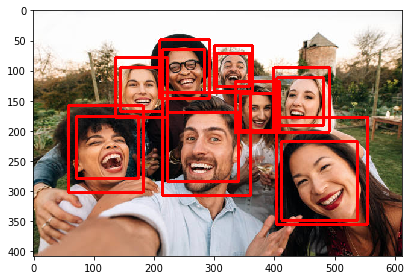

In [12]:
#plot (return image) with bounding boxes only (don't draw landmarks on)
faces, face_emotions, new_img= main(image_path, credintial_path)
sio.imshow(new_img)

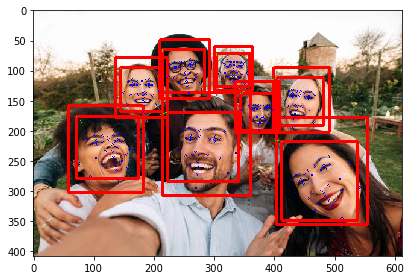

In [8]:
#plot (return image) with bounding boxes and draw landmarks on 
faces, face_emotions, new_img= main(image_path, credintial_path,True)
sio.imshow(new_img)

In [9]:
print(face_emotions)

{0: [{'Angry likelyhood': 'Very Unlikely'}, {'Joy likelyhood': 'Very Likely'}, {'Sorrow likelyhood': 'Very Unlikely'}, {'Surprised ikelihood': 'Very Unlikely'}, {'Headwear likelyhood': 'Likely'}], 1: [{'Angry likelyhood': 'Very Unlikely'}, {'Joy likelyhood': 'Very Likely'}, {'Sorrow likelyhood': 'Very Unlikely'}, {'Surprised ikelihood': 'Very Unlikely'}, {'Headwear likelyhood': 'Unlikely'}], 2: [{'Angry likelyhood': 'Very Unlikely'}, {'Joy likelyhood': 'Very Likely'}, {'Sorrow likelyhood': 'Very Unlikely'}, {'Surprised ikelihood': 'Very Unlikely'}, {'Headwear likelyhood': 'Very Unlikely'}], 3: [{'Angry likelyhood': 'Very Unlikely'}, {'Joy likelyhood': 'Likely'}, {'Sorrow likelyhood': 'Very Unlikely'}, {'Surprised ikelihood': 'Very Unlikely'}, {'Headwear likelyhood': 'Very Unlikely'}], 4: [{'Angry likelyhood': 'Very Unlikely'}, {'Joy likelyhood': 'Possibly'}, {'Sorrow likelyhood': 'Very Unlikely'}, {'Surprised ikelihood': 'Very Unlikely'}, {'Headwear likelyhood': 'Very Unlikely'}], 5: [

In [10]:
'''
- faces is a dictionary that its keys are numbers from 0 to len(persons)-1
its values are list of lists.
for each face,list 0 is the points of the large bounding box,
list 1 is for the smaller bounding box, list 2 is list of lists that every list
inside it refers to one of the landmarks by the order that'll be mentioned below.
list 3 is roll angle, list 4 is pan angle and list 5 is tilt angle.

- face_emotions is also a dictionary as above but its values are list of dictionaries.
each dictionary in this list refers to the status of the person as if he/she is smiling, angry,..., wearing hat
(there's an example above shows everything)

- the last thing returned is the image itself after drawing the bounding boxes on and the landmarks(optional)
'''

"\n- faces is a dictionary that its keys are numbers from 0 to len(persons)-1\nits values are list of lists.\nfor each face,list 0 is the points of the large bounding box,\nlist 1 is for the smaller bounding box, list 2 is list of lists that every list\ninside it refers to one of the landmarks by the order that'll be mentioned below.\nlist 3 is roll angle, list 4 is pan angle and list 5 is tilt angle.\n\n- face_emotions is also a dictionary as above but its values are list of dictionaries.\neach dictionary in this list refers to the status of the person as if he/she is smiling, angry,..., wearing hat\n(there's an example above shows everything)\n\n- the last thing returned is the image itself after drawing the bounding boxes on and the landmarks(optional)\n"

In [11]:
# order of landmarks

# [type: LEFT_EYE
# , type: RIGHT_EYE
# , type: LEFT_OF_LEFT_EYEBROW
# , type: RIGHT_OF_LEFT_EYEBROW
# , type: LEFT_OF_RIGHT_EYEBROW
# , type: MIDPOINT_BETWEEN_EYES
# , type: NOSE_TIP
# , type: UPPER_LIP
# , type: LOWER_LIP
# , type: MOUTH_LEFT
# , type: MOUTH_RIGHT
# , type: MOUTH_CENTER
# , type: NOSE_BOTTOM_RIGHT
# , type: NOSE_BOTTOM_LEFT
# , type: NOSE_BOTTOM_CENTER
# , type: LEFT_EYE_TOP_BOUNDARY
# , type: LEFT_EYE_RIGHT_CORNER
# , type: LEFT_EYE_BOTTOM_BOUNDARY
# , type: LEFT_EYE_LEFT_CORNER
# , type: RIGHT_EYE_TOP_BOUNDARY
# , type: RIGHT_EYE_RIGHT_CORNER
# , type: RIGHT_EYE_BOTTOM_BOUNDARY
# , type: RIGHT_EYE_LEFT_CORNER
# , type: LEFT_EYEBROW_UPPER_MIDPOINT
# , type: RIGHT_EYEBROW_UPPER_MIDPOINT
# , type: LEFT_EAR_TRAGION
# , type: RIGHT_EAR_TRAGION
# , type: FOREHEAD_GLABELLA
# , type: CHIN_GNATHION
# , type: CHIN_LEFT_GONION
# , type: CHIN_RIGHT_GONION